## Table of Contents:
* [EDA](#EDA)
* [Creating Baseline Model](#CBA)
* [First Test Data Submission Attempt Using our Fourth Model](#FTDS)
* [Polynomial Features with Ridge Regression](#PFRR)
* [Small Lasso Model](#SLM)
* [Plotting Model Performance](#PFM)
* [Final Test Data Submission](#FTD)

In [1]:
# Importing libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression, RidgeCV
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import LinearRegression, Ridge, RidgeCV, Lasso, LassoCV

# getting rid of pesky warnings
import warnings
warnings.filterwarnings('ignore')

## EDA <a class="anchor" id="EDA"></a>


In [2]:
# Read in data
data = pd.read_csv('./datasets/train.csv')
test = pd.read_csv('./datasets/test.csv')
warnings.filterwarnings('ignore')

In [3]:
# so we can always see the full extent of the data (this was 999, but for notebook readibility I have reduced it to 20)
pd.options.display.max_rows = 20
pd.options.display.max_columns = 999

In [4]:
# Check null values of test data
test.isna().sum()

Id                0
PID               0
MS SubClass       0
MS Zoning         0
Lot Frontage    160
               ... 
Misc Feature    837
Misc Val          0
Mo Sold           0
Yr Sold           0
Sale Type         0
Length: 80, dtype: int64

**Cleaning Test Data**

In [5]:
# gotta clean the test data, cannot drop any rows so we have to replace nan with values that reflect 'nan'

In [6]:
# change lot frontage nan to 0 since it is continuous

test.loc[(test['Lot Frontage'].isna()), ['Lot Frontage']] = 0

In [7]:
# change alley to 'NA' since it is nominal

test.loc[(test['Alley'].isna()), ['Alley']] = 'NA'

In [8]:
# change mas vnr type to 'NA' since it is nominal

test.loc[(test['Mas Vnr Type'].isna()), ['Mas Vnr Type']] = 'NA'

In [9]:
# change mas vnr area to 0 since it is continuous

test.loc[(test['Mas Vnr Area'].isna()), ['Mas Vnr Area']] = 0

In [10]:
# change all bsmt values to 'NA' if no basement and it is ordinal/nominal

test.loc[(test['BsmtFin Type 1'].isna()), ['Bsmt Qual',
                                           'Bsmt Cond',
                                           'Bsmt Exposure',
                                           'BsmtFin Type 1',
                                           'BsmtFin Type 2']] = 'NA'

In [11]:
# change electrical to ? if nan as we don't know what nan values for electrical mean

test.loc[(test['Electrical'].isna()), ['Electrical']] = '?'

In [12]:
# change Fireplace Qu to 'NA' since it is ordinal

test.loc[(test['Fireplace Qu'].isna()), ['Fireplace Qu']] = 'NA'

In [13]:
# changing all garage values to 'NA' if no garage and it is ordinal/nominal

test.loc[(test['Garage Yr Blt'].isna()), 
                                         ['Garage Type',
                                        'Garage Finish',
                                        'Garage Qual',
                                        'Garage Cond']] = 'NA'

#this is for the weird one that was chilling on the side
test.loc[(test['Garage Finish'].isna()), ['Garage Finish', 'Garage Qual', 'Garage Cond']] = 'NA'

#changing garage year to 0 since it is continuous

test.loc[(test['Garage Yr Blt'].isna()), ['Garage Yr Blt']] = 0

In [14]:
# changing pool to 'NA' since it is ordinal

test.loc[(test['Pool QC'].isna()), ['Pool QC']] = 'NA'

In [15]:
# changing fence to 'NA' since it is ordinal

test.loc[(test['Fence'].isna()), ['Fence']] = 'NA'

In [16]:
# changing misc feature to 'NA' if no misc feature

test.loc[(test['Misc Feature'].isna()), ['Misc Feature']] = 'NA'

In [17]:
# Now our test data set is cleaned and ready to be modified

In [18]:
# Quick check to see what we are dealing with in our training data
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2051 entries, 0 to 2050
Data columns (total 81 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Id               2051 non-null   int64  
 1   PID              2051 non-null   int64  
 2   MS SubClass      2051 non-null   int64  
 3   MS Zoning        2051 non-null   object 
 4   Lot Frontage     1721 non-null   float64
 5   Lot Area         2051 non-null   int64  
 6   Street           2051 non-null   object 
 7   Alley            140 non-null    object 
 8   Lot Shape        2051 non-null   object 
 9   Land Contour     2051 non-null   object 
 10  Utilities        2051 non-null   object 
 11  Lot Config       2051 non-null   object 
 12  Land Slope       2051 non-null   object 
 13  Neighborhood     2051 non-null   object 
 14  Condition 1      2051 non-null   object 
 15  Condition 2      2051 non-null   object 
 16  Bldg Type        2051 non-null   object 
 17  House Style   

In [19]:
data.describe()

,Id,PID,MS SubClass,Lot Frontage,Lot Area,Overall Qual,Overall Cond,Year Built,Year Remod/Add,Mas Vnr Area,BsmtFin SF 1,BsmtFin SF 2,Bsmt Unf SF,Total Bsmt SF,1st Flr SF,2nd Flr SF,Low Qual Fin SF,Gr Liv Area,Bsmt Full Bath,Bsmt Half Bath,Full Bath,Half Bath,Bedroom AbvGr,Kitchen AbvGr,TotRms AbvGrd,Fireplaces,Garage Yr Blt,Garage Cars,Garage Area,Wood Deck SF,Open Porch SF,Enclosed Porch,3Ssn Porch,Screen Porch,Pool Area,Misc Val,Mo Sold,Yr Sold,SalePrice
count,2051.000000,2.051000e+03,2051.000000,1721.000000,2051.000000,2051.000000,2051.000000,2051.000000,2051.000000,2029.000000,2050.000000,2050.000000,2050.000000,2050.000000,2051.000000,2051.000000,2051.000000,2051.000000,2049.000000,2049.000000,2051.000000,2051.000000,2051.000000,2051.000000,2051.000000,2051.000000,1937.000000,2050.000000,2050.000000,2051.000000,2051.000000,2051.000000,2051.000000,2051.000000,2051.000000,2051.000000,2051.000000,2051.000000,2051.000000
mean,1474.033642,7.135900e+08,57.008776,69.055200,10065.208191,6.112140,5.562165,1971.708922,1984.190151,99.695909,442.300488,47.959024,567.728293,1057.987805,1164.488055,329.329108,5.512921,1499.330083,0.427526,0.063446,1.577279,0.371039,2.843491,1.042906,6.435885,0.590931,1978.707796,1.776585,473.671707,93.833740,47.556802,22.571916,2.591419,16.511458,2.397855,51.574354,6.219893,2007.775719,181469.701609
std,843.980841,1.886918e+08,42.824223,23.260653,6742.488909,1.426271,1.104497,30.177889,21.036250,174.963129,461.204124,165.000901,444.954786,449.410704,396.446923,425.671046,51.068870,500.447829,0.522673,0.251705,0.549279,0.501043,0.826618,0.209790,1.560225,0.638516,25.441094,0.764537,215.934561,128.549416,66.747241,59.845110,25.229615,57.374204,37.782570,573.393985,2.744736,1.312014,79258.659352
min,1.000000,5.263011e+08,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,0.000000,0.000000,0.000000,334.000000,0.000000,0.000000,334.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,1895.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,12789.000000
25%,753.500000,5.284581e+08,20.000000,58.000000,7500.000000,5.000000,5.000000,1953.500000,1964.500000,0.000000,0.000000,0.000000,220.000000,793.000000,879.500000,0.000000,0.000000,1129.000000,0.000000,0.000000,1.000000,0.000000,2.000000,1.000000,5.000000,0.000000,1961.000000,1.000000,319.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000,2007.000000,129825.000000
50%,1486.000000,5.354532e+08,50.000000,68.000000,9430.000000,6.000000,5.000000,1974.000000,1993.000000,0.000000,368.000000,0.000000,474.500000,994.500000,1093.000000,0.000000,0.000000,1444.000000,0.000000,0.000000,2.000000,0.000000,3.000000,1.000000,6.000000,1.000000,1980.000000,2.000000,480.000000,0.000000,27.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,162500.000000
75%,2198.000000,9.071801e+08,70.000000,80.000000,11513.500000,7.000000,6.000000,2001.000000,2004.000000,161.000000,733.750000,0.000000,811.000000,1318.750000,1405.000000,692.500000,0.000000,1728.500000,1.000000,0.000000,2.000000,1.000000,3.000000,1.000000,7.000000,1.000000,2002.000000,2.000000,576.000000,168.000000,70.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,2930.000000,9.241520e+08,190.000000,313.000000,159000.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,1474.000000,2336.000000,6110.000000,5095.000000,1862.000000,1064.000000,5642.000000,3.000000,2.000000,4.000000,2.000000,8.000000,3.000000,15.000000,4.000000,2207.000000,5.000000,1418.000000,1424.000000,547.000000,432.000000,508.000000,490.000000,800.000000,17000.000000,12.000000,2010.000000,611657.000000


In [20]:
data.head(10)

,Id,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,Utilities,Lot Config,Land Slope,Neighborhood,Condition 1,Condition 2,Bldg Type,House Style,Overall Qual,Overall Cond,Year Built,Year Remod/Add,Roof Style,Roof Matl,Exterior 1st,Exterior 2nd,Mas Vnr Type,Mas Vnr Area,Exter Qual,Exter Cond,Foundation,Bsmt Qual,Bsmt Cond,Bsmt Exposure,BsmtFin Type 1,BsmtFin SF 1,BsmtFin Type 2,BsmtFin SF 2,Bsmt Unf SF,Total Bsmt SF,Heating,Heating QC,Central Air,Electrical,1st Flr SF,2nd Flr SF,Low Qual Fin SF,Gr Liv Area,Bsmt Full Bath,Bsmt Half Bath,Full Bath,Half Bath,Bedroom AbvGr,Kitchen AbvGr,Kitchen Qual,TotRms AbvGrd,Functional,Fireplaces,Fireplace Qu,Garage Type,Garage Yr Blt,Garage Finish,Garage Cars,Garage Area,Garage Qual,Garage Cond,Paved Drive,Wood Deck SF,Open Porch SF,Enclosed Porch,3Ssn Porch,Screen Porch,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,SalePrice
0,109,533352170,60,RL,NaN,13517,Pave,NaN,IR1,Lvl,AllPub,CulDSac,Gtl,Sawyer,RRAe,Norm,1Fam,2Story,6,8,1976,2005,Gable,CompShg,HdBoard,Plywood,BrkFace,289.0,Gd,TA,CBlock,TA,TA,No,GLQ,533.0,Unf,0.0,192.0,725.0,GasA,Ex,Y,SBrkr,725,754,0,1479,0.0,0.0,2,1,3,1,Gd,6,Typ,0,NaN,Attchd,1976.0,RFn,2.0,475.0,TA,TA,Y,0,44,0,0,0,0,NaN,NaN,NaN,0,3,2010,WD,130500
1,544,531379050,60,RL,43.0,11492,Pave,NaN,IR1,Lvl,AllPub,CulDSac,Gtl,SawyerW,Norm,Norm,1Fam,2Story,7,5,1996,1997,Gable,CompShg,VinylSd,VinylSd,BrkFace,132.0,Gd,TA,PConc,Gd,TA,No,GLQ,637.0,Unf,0.0,276.0,913.0,GasA,Ex,Y,SBrkr,913,1209,0,2122,1.0,0.0,2,1,4,1,Gd,8,Typ,1,TA,Attchd,1997.0,RFn,2.0,559.0,TA,TA,Y,0,74,0,0,0,0,NaN,NaN,NaN,0,4,2009,WD,220000
2,153,535304180,20,RL,68.0,7922,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Norm,Norm,1Fam,1Story,5,7,1953,2007,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,Gd,CBlock,TA,TA,No,GLQ,731.0,Unf,0.0,326.0,1057.0,GasA,TA,Y,SBrkr,1057,0,0,1057,1.0,0.0,1,0,3,1,Gd,5,Typ,0,NaN,Detchd,1953.0,Unf,1.0,246.0,TA,TA,Y,0,52,0,0,0,0,NaN,NaN,NaN,0,1,2010,WD,109000
3,318,916386060,60,RL,73.0,9802,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Timber,Norm,Norm,1Fam,2Story,5,5,2006,2007,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,PConc,Gd,TA,No,Unf,0.0,Unf,0.0,384.0,384.0,GasA,Gd,Y,SBrkr,744,700,0,1444,0.0,0.0,2,1,3,1,TA,7,Typ,0,NaN,BuiltIn,2007.0,Fin,2.0,400.0,TA,TA,Y,100,0,0,0,0,0,NaN,NaN,NaN,0,4,2010,WD,174000
4,255,906425045,50,RL,82.0,14235,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,SawyerW,Norm,Norm,1Fam,1.5Fin,6,8,1900,1993,Gable,CompShg,Wd Sdng,Plywood,None,0.0,TA,TA,PConc,Fa,Gd,No,Unf,0.0,Unf,0.0,676.0,676.0,GasA,TA,Y,SBrkr,831,614,0,1445,0.0,0.0,2,0,3,1,TA,6,Typ,0,NaN,Detchd,1957.0,Unf,2.0,484.0,TA,TA,N,0,59,0,0,0,0,NaN,NaN,NaN,0,3,2010,WD,138500
5,138,535126040,20,RL,137.0,16492,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,NAmes,PosA,Norm,1Fam,1Story,6,6,1966,2002,Gable,CompShg,BrkFace,Plywood,None,0.0,Gd,TA,CBlock,TA,TA,No,ALQ,247.0,Rec,713.0,557.0,1517.0,GasA,Ex,Y,SBrkr,1888,0,0,1888,0.0,0.0,2,1,2,1,Gd,6,Mod,1,Gd,Attchd,1966.0,Fin,2.0,578.0,TA,TA,Y,0,0,0,0,0,0,NaN,NaN,NaN,0,6,2010,WD,190000
6,2827,908186070,180,RM,35.0,3675,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Edwards,Norm,Norm,TwnhsE,SFoyer,6,5,2005,2006,Gable,CompShg,VinylSd,VinylSd,BrkFace,82.0,TA,TA,PConc,Gd,TA,Gd,GLQ,547.0,Unf,0.0,0.0,547.0,GasA,Gd,Y,SBrkr,1072,0,0,1072,1.0,0.0,2,0,2,1,TA,5,Typ,0,NaN,Basment,2005.0,Fin,2.0,525.0,TA,TA,Y,0,44,0,0,0,0,NaN,NaN,NaN,0,6,2006,New,140000
7,145,535154050,20,RL,NaN,12160,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,NAmes,Norm,Norm,1Fam,1Story,5,5,1959,1959,Hip,CompShg,Plywood,Plywood,BrkFace,180.0,TA,TA,CBlock,TA,TA,No,Rec,1000.0,Unf,0.0,188.0,1188.0,GasA,Fa,Y,SBrkr,1188,0,0,1188,1.0,0.0,1,0,3,1,TA,6,Typ,0,NaN,Attchd,1959.0,RFn,2.0,531.0,TA,TA,Y,0,0,0,0,0,0,NaN,MnPrv,NaN,0,5,2010,COD,142000
8,1942,535353130,20,RL,NaN,15783,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,OldTown,Artery,Norm,1Fam,1Story,5,5,1952,1952,Gable,CompShg,Wd Sdng,Wd Sdng,None,0.0,TA,TA,CBlock,TA,TA,No,Rec,292.0,Unf,0.0,632.0,924.0,GasA,TA,Y,SBrkr,924,0,0,924,0.0,0.0,1,0,2,1,TA,6,Typ,0,NaN,Detchd,1952.0,Unf,1.0,420.0,TA,TA,Y,

In [21]:
#create new 'cleaned' data sets so we can always reference the original data
cdata = data
ctest = test
cdata.set_index('Id', inplace = True)
ctest.set_index('Id', inplace = True)


# Creating Baseline Model <a class="anchor" id="CBA"></a>

In [22]:
#Functions to get quick correlations between features

#function to get correlation between numerical features and saleprice
def corrmap(features, data):
    df = data[features].to_frame()
    df['SalePrice'] = data['SalePrice']
    return df.corr()['SalePrice'].sort_values()

#function to get correlation between categorical features and saleprice
def corrmapdum(features, data):
    df = pd.get_dummies(data[features], drop_first = True)
    df['SalePrice'] = data['SalePrice']
    return df.corr()['SalePrice'].sort_values()
    

In [23]:
#This loops through the dataset, calculates the corr matrix for each features, and separates them into lists where 
# 'strong' is features that have a .4 or higher corrlation with price and
# 'weak' is features that have a .2 - .39 correlation with price
# LET ME LOOP THROUGH AND DO ALL I DID AUTOMATICALLY 

names = list(df_dummied)

for i,k in enumerate (names):
    if dummied[k].dtypes == object:
        if np.absolute(corrmapdum(k, cdata).head(1).values) >= .4 :
            strong.append(k)
        elif np.absolute(corrmapdum(k, cdata).head(1).values) >= .2:
            weak.append(k)
    else:
        if np.absolute(corrmap(k, cdata).head(1).values) >= .4:
            strong.append(k)
        elif np.absolute(corrmap(k, cdata).head(1).values) >= .2:
            weak.append(k)


In [24]:
# Checking for na values with our selected dataset
cdata[strong].isna().sum()

Overall Qual        0
Year Built          0
Year Remod/Add      0
Mas Vnr Type       22
Mas Vnr Area       22
Exter Qual          0
Bsmt Qual          55
BsmtFin SF 1        1
Total Bsmt SF       1
1st Flr SF          0
Gr Liv Area         0
Full Bath           0
Kitchen Qual        0
TotRms AbvGrd       0
Fireplaces          0
Garage Yr Blt     114
Garage Finish     114
Garage Cars         1
Garage Area         1
SalePrice           0
dtype: int64

In [25]:
#creating new df with just the strong features
cstrong = cdata[strong]

In [26]:
#dropping rows with na values from the dataframe/lazy way to deal with nans since this will not be our final dataset
cstrong = cstrong.dropna()

In [27]:
# Making strong into dummies
cstrong = pd.get_dummies(cstrong)

**First Model**

In [28]:
#making first model with just the 'strong' features
#this is ok, but can be better
X = cstrong.drop('SalePrice', axis = 1)
y = cstrong['SalePrice']
lr = LinearRegression()
print(cross_val_score(lr, X, y))
print(cross_val_score(lr, X, y).mean())

[0.84152233 0.8863921  0.73132251 0.86482374 0.77434622]
0.8196813797570373


In [29]:
cweak = cdata[strong + weak]

In [30]:
cweak.isna().sum()

Overall Qual        0
Year Built          0
Year Remod/Add      0
Mas Vnr Type       22
Mas Vnr Area       22
                 ... 
Half Bath           0
Garage Type       113
Wood Deck SF        0
Open Porch SF       0
Sale Type           0
Length: 38, dtype: int64

**Cleaning the features we will use for all our models going forward**

In [31]:
#we're going to go through and manually fix each na value, cannot drop 


In [32]:
# changing mas vnr type to 'None' if no vnr
# changing mas vnr area to 0 if no vnr
cweak.loc[(cweak['Mas Vnr Type'].isna()), ['Mas Vnr Type']] = 'None'
cweak.loc[(cweak['Mas Vnr Area'].isna()), ['Mas Vnr Area']] = 0

In [33]:
# changing basmt qual to 'NA' if it doesn't exist 
cweak.loc[(cweak['Bsmt Qual'].isna()), ['Bsmt Qual']] = 'NA'

In [34]:
# changing bsmt sf 1 to 0 if it doesn't exist
cweak.loc[(cweak['BsmtFin SF 1'].isna()), ['BsmtFin SF 1']] = 0

In [35]:
# changing total bsmt sf to 0 if it doesn't exist
cweak.loc[(cweak['Total Bsmt SF'].isna()), ['Total Bsmt SF']] = 0

In [36]:
# changing garage yr blt to 0 if no garage

cweak.loc[(cweak['Garage Yr Blt'].isna()), ['Garage Yr Blt']] = 0

# changing garage finish to 'na' if no garage

cweak.loc[(cweak['Garage Finish'].isna()), ['Garage Finish']] = 'NA'

# changing garage cars and area to 0 if nan

cweak.loc[(cweak['Garage Cars'].isna()), ['Garage Cars', 'Garage Area']] = 0

In [37]:
# changing lot frontage to 0 if na

cweak.loc[(cweak['Lot Frontage'].isna()), ['Lot Frontage']] = 0

In [38]:
# changing bsmt exposure to 'na' if it doesn't exist

cweak.loc[(cweak['Bsmt Exposure'].isna()), ['Bsmt Exposure']] = 'NA'

In [39]:
# changing bsmt full bath to 0 if no bath

cweak.loc[(cweak['Bsmt Full Bath'].isna()), ['Bsmt Full Bath']] = 0

In [40]:
# changing garage type to NA if no garage
cweak.loc[(cweak['Garage Type'].isna()), ['Garage Type']] = 'NA'

In [41]:
# redefine our cleaned data 
cdata = cweak
cweak = pd.get_dummies(cweak)
cweak.head()

,Overall Qual,Year Built,Year Remod/Add,Mas Vnr Area,BsmtFin SF 1,Total Bsmt SF,1st Flr SF,Gr Liv Area,Full Bath,TotRms AbvGrd,Fireplaces,Garage Yr Blt,Garage Cars,Garage Area,SalePrice,PID,Lot Frontage,Lot Area,2nd Flr SF,Bsmt Full Bath,Half Bath,Wood Deck SF,Open Porch SF,Mas Vnr Type_BrkCmn,Mas Vnr Type_BrkFace,Mas Vnr Type_None,Mas Vnr Type_Stone,Exter Qual_Ex,Exter Qual_Fa,Exter Qual_Gd,Exter Qual_TA,Bsmt Qual_Ex,Bsmt Qual_Fa,Bsmt Qual_Gd,Bsmt Qual_NA,Bsmt Qual_Po,Bsmt Qual_TA,Kitchen Qual_Ex,Kitchen Qual_Fa,Kitchen Qual_Gd,Kitchen Qual_TA,Garage Finish_Fin,Garage Finish_NA,Garage Finish_RFn,Garage Finish_Unf,MS Zoning_A (agr),MS Zoning_C (all),MS Zoning_FV,MS Zoning_I (all),MS Zoning_RH,MS Zoning_RL,MS Zoning_RM,Lot Shape_IR1,Lot Shape_IR2,Lot Shape_IR3,Lot Shape_Reg,Neighborhood_Blmngtn,Neighborhood_Blueste,Neighborhood_BrDale,Neighborhood_BrkSide,Neighborhood_ClearCr,Neighborhood_CollgCr,Neighborhood_Crawfor,Neighborhood_Edwards,Neighborhood_Gilbert,Neighborhood_Greens,Neighborhood_GrnHill,Neighborhood_IDOTRR,Neighborhood_Landmrk,Neighborhood_MeadowV,Neighborhood_Mitchel,Neighborhood_NAmes,Neighborhood_NPkVill,Neighborhood_NWAmes,Neighborhood_NoRidge,Neighborhood_NridgHt,Neighborhood_OldTown,Neighborhood_SWISU,Neighborhood_Sawyer,Neighborhood_SawyerW,Neighborhood_Somerst,Neighborhood_StoneBr,Neighborhood_Timber,Neighborhood_Veenker,Roof Style_Flat,Roof Style_Gable,Roof Style_Gambrel,Roof Style_Hip,Roof Style_Mansard,Roof Style_Shed,Foundation_BrkTil,Foundation_CBlock,Foundation_PConc,Foundation_Slab,Foundation_Stone,Foundation_Wood,Bsmt Exposure_Av,Bsmt Exposure_Gd,Bsmt Exposure_Mn,Bsmt Exposure_NA,Bsmt Exposure_No,Heating QC_Ex,Heating QC_Fa,Heating QC_Gd,Heating QC_Po,Heating QC_TA,Central Air_N,Central Air_Y,Garage Type_2Types,Garage Type_Attchd,Garage Type_Basment,Garage Type_BuiltIn,Garage Type_CarPort,Garage Type_Detchd,Garage Type_NA,Sale Type_COD,Sale Type_CWD,Sale Type_Con,Sale Type_ConLD,Sale Type_ConLI,Sale Type_ConLw,Sale Type_New,Sale Type_Oth,Sale Type_WD
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
109,6,1976,2005,289.0,533.0,725.0,725,1479,2,6,0,1976.0,2.0,475.0,130500,533352170,0.0,13517,754,0.0,1,0,44,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1
544,7,1996,1997,132.0,637.0,913.0,913,2122,2,8,1,1997.0,2.0,559.0,220000,531379050,43.0,11492,1209,1.0,1,0,74,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1
153,5,1953,2007,0.0,731.0,1057.0,1057,1057,1,5,0,1953.0,1.0,246.0,109000,535304180,68.0,7922,0,1.0,0,0,52,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1
318,5,2006,2007,0.0,0.0,384.0,744,1444,2,7,0,2007.0,2.0,400.0,174000,916386060,73.0,9802,700,0.0,1,100,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1
255,6,1900,1993,0.0,0.0,676.0,831,1445,2,6,0,1957.0,2.0,484.0,138500,906425045,82.0,14235,614,0.0,0,0,59,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1


**Second Model**

In [42]:
#model with the strong and weak features, a decent amount stronger
X1 = cweak.drop('SalePrice', axis = 1)
y1 = cweak['SalePrice']
lr1 = LinearRegression()
print(cross_val_score(lr, X1, y1))
print(cross_val_score(lr, X1, y1).mean())

[0.89102631 0.90826648 0.7963467  0.88072526 0.81268399]
0.8578097477768394


In [43]:
# Look at all correlations with the dummies, going to make a new list with values higher than .4
cweak.corr()['SalePrice'].sort_values(ascending = False)

SalePrice            1.000000
Overall Qual         0.800207
Gr Liv Area          0.697038
Garage Area          0.649897
Garage Cars          0.647781
                       ...   
Mas Vnr Type_None   -0.411170
Garage Finish_Unf   -0.432220
Bsmt Qual_TA        -0.456979
Kitchen Qual_TA     -0.540860
Exter Qual_TA       -0.600362
Name: SalePrice, Length: 124, dtype: float64

In [44]:
# make new list of strong correlations with dummified data
names2 = list(cweak)
strong2 = []

for i,k in enumerate (names2):
    if cweak[k].dtypes == object:
        if np.absolute(corrmapdum(k, cweak).head(1).values) >= .15 :
            strong2.append(k)
    else:
        if np.absolute(corrmap(k, cweak).head(1).values) >= .15:
            strong2.append(k)


**Third Model**

In [45]:
# make new model with strong 2 and see if it's any stronger
lr = LinearRegression()
X2 = cweak[strong2].drop('SalePrice', axis = 1)
y2 = cweak['SalePrice']
cross_val_score(lr, X2, y2).mean()

0.8557282368145686

In [46]:
#now we have our strong correlated columns for our dummified data, we're going to look through each of the dummified columns 
# and see if they affect the price by > 20000, if they do we will add them to the list of strong columns
strong3 = []
for v in cweak.drop('SalePrice', axis = 1).columns:
    X = cweak[[v]]
    y = cweak['SalePrice']
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 69)
    lr = LinearRegression()
    lr.fit(X_train, y_train)
    if np.absolute(lr.coef_) > 20000:
        strong3.append(v)

In [47]:
# now we will combine strong 3 and 2 to get all good dummy columns
for v in strong2:
    if v in strong3:
        pass
    else:
        strong3.append(v)

**Fourth Model**

In [48]:
lr = LinearRegression()
X3 = cweak[strong3].drop('SalePrice', axis = 1)
y3 = cweak['SalePrice']
print(cross_val_score(lr, X3, y3))
print(cross_val_score(lr, X3, y3).mean())

[0.89045679 0.90835237 0.79730214 0.88108236 0.81290717]
0.858020165271309


Text(0, 0.5, 'Residual')

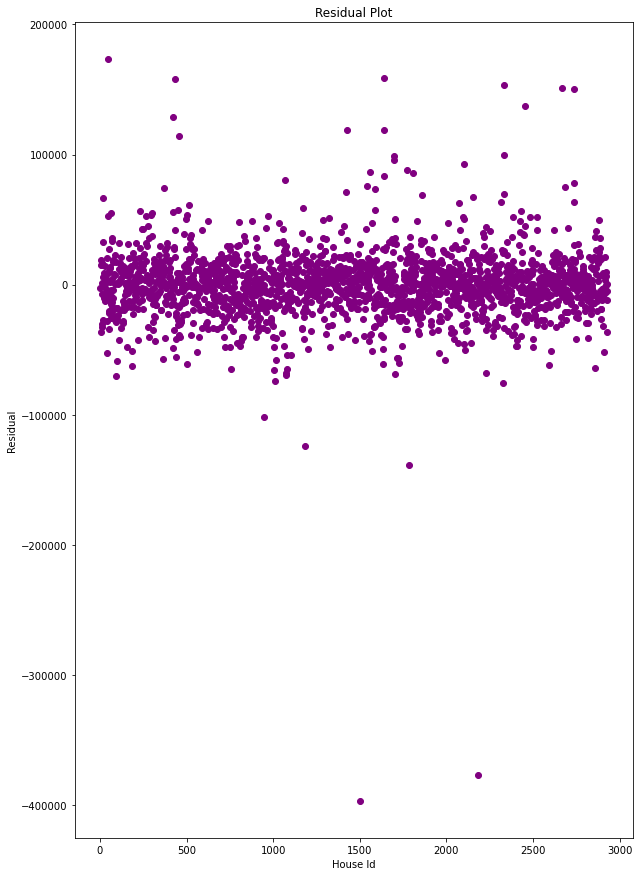

In [49]:
#Plotting residuals for the fourth model, it seems decently distributed however there are some outliers (two really big ones)
plt.figure(figsize = (10, 15))
lr.fit(X3, y3)
residuals = y3 - lr.predict(X3)
plt.plot(residuals, 'o', color='purple')
plt.title("Residual Plot")
plt.xlabel("House Id")
plt.ylabel("Residual")

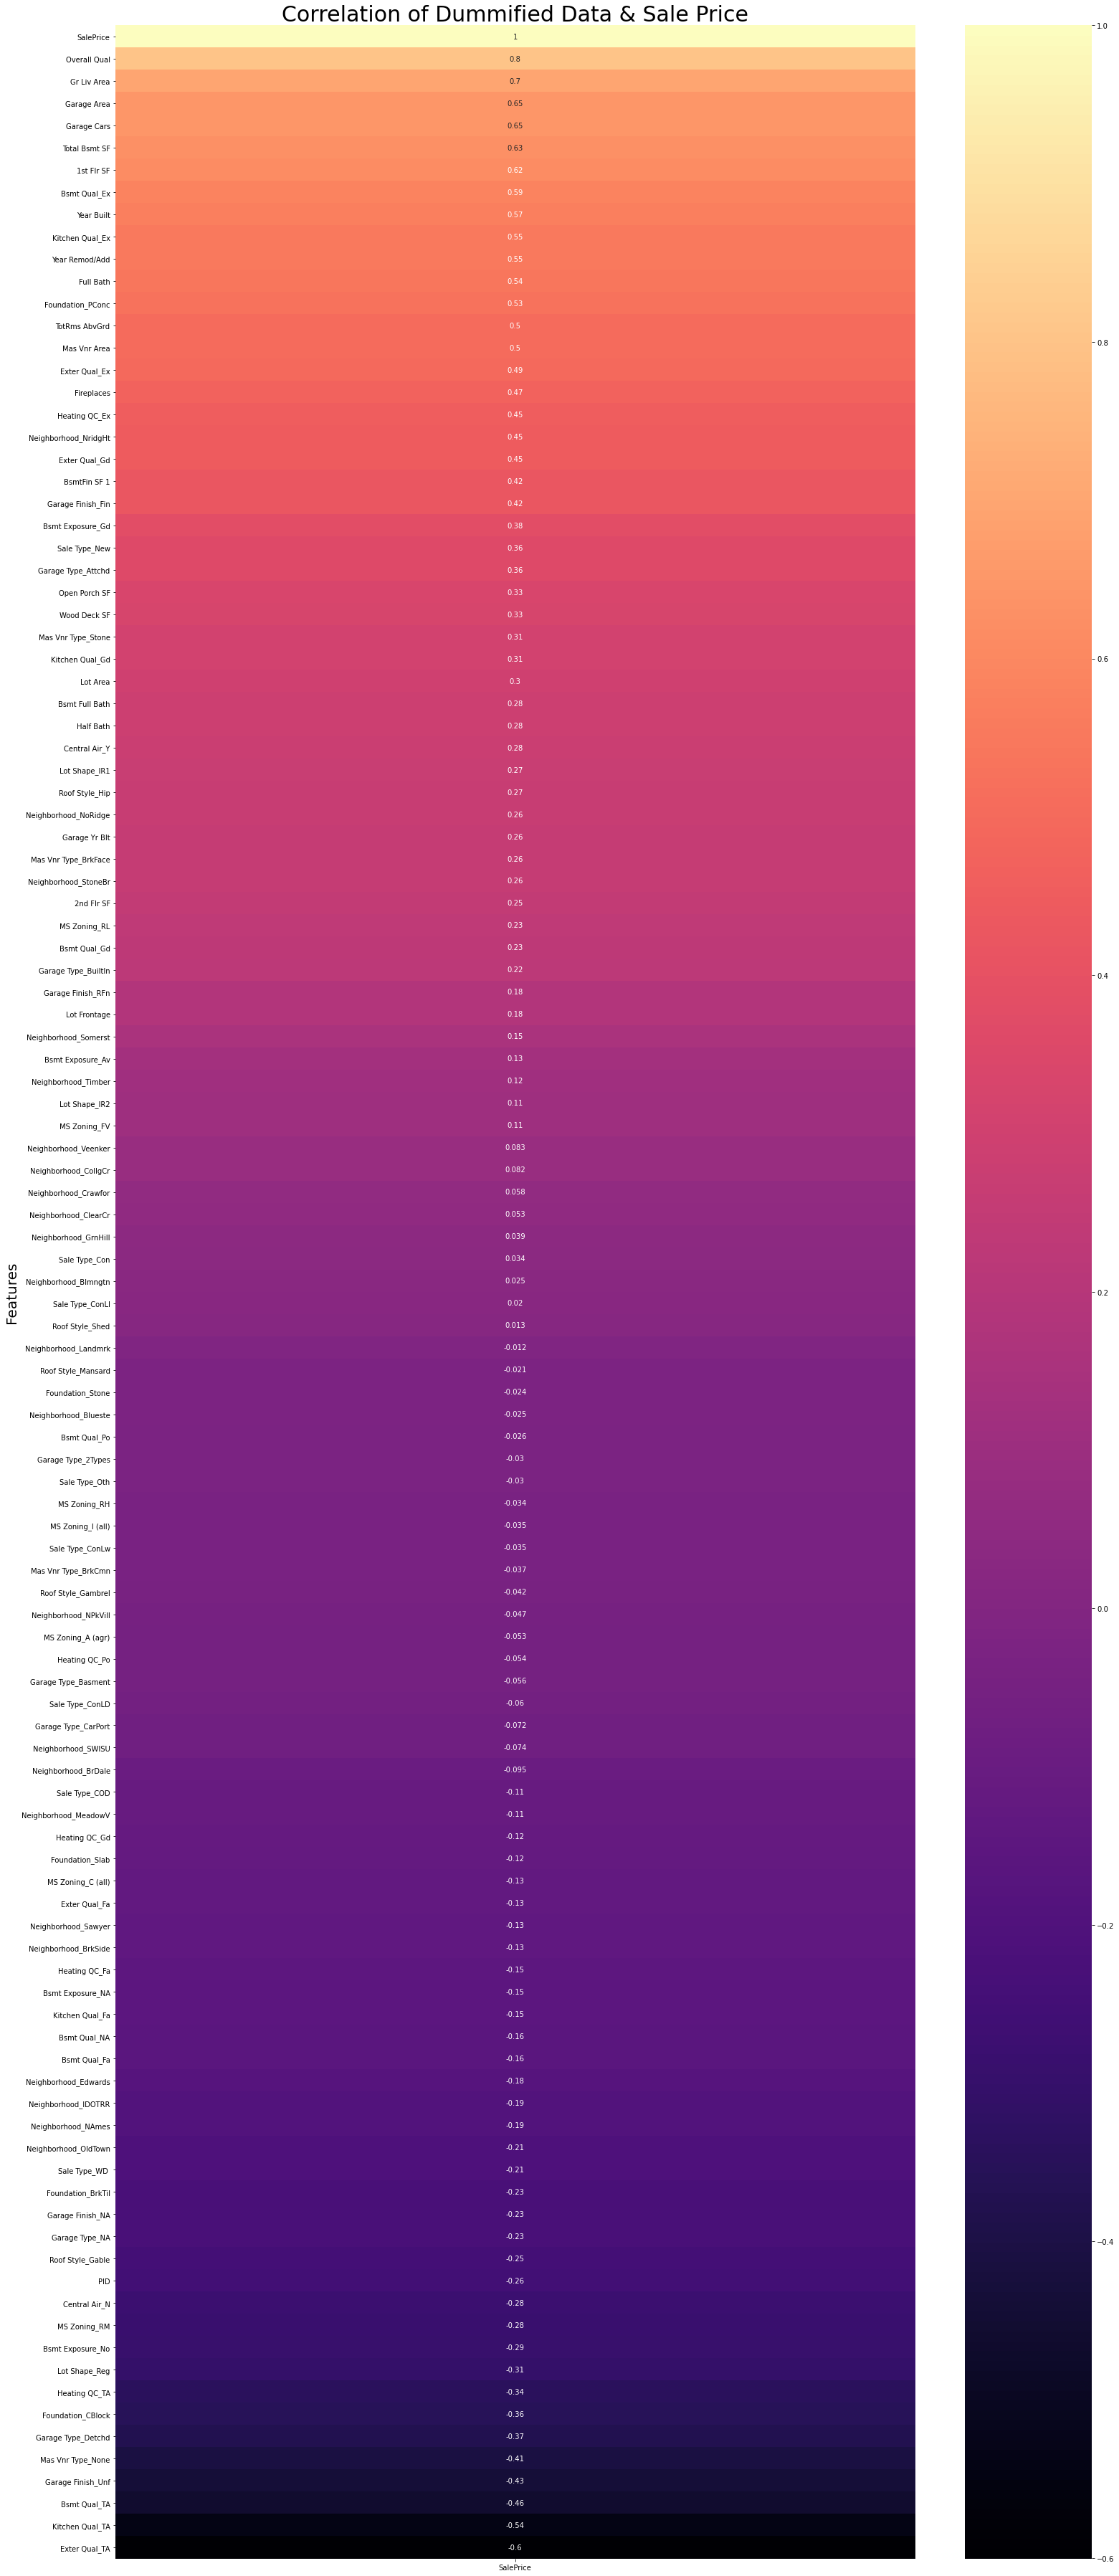

In [50]:
# Heatmap showing interaction correlations
plt.figure(figsize=(25,65))
plycr = sns.heatmap(cweak[strong3].corr()[['SalePrice']].sort_values('SalePrice', ascending = False), annot = True, cmap = 'magma')
plycr.set_ylabel('Features', fontsize = 20.0)
plycr.set_title('Correlation of Dummified Data & Sale Price', fontsize = 30)
plycr.tick_params(axis="x", labelsize=10);

# First Test Data Submission Attempt Using our Fourth Model <a class="anchor" id="FTDS"></a>


In [51]:
ctest = pd.get_dummies(test)

In [52]:
# check for missing columns in test
missX = list(set(X3.columns) - set(ctest.columns))

# Check for missing columns in train
missT = list(set(ctest.columns) - set(X3.columns))

for i in missX:
    ctest[i] = 0

ctest['SalePrice'] = 0
testctest = ctest[strong3]

In [53]:
# checking shapes of data to make sure they're the same
X3.shape

(2051, 113)

In [54]:
# this has one more because it has a dummy 'SalePrice' column
testctest.shape

(878, 114)

In [55]:
# double checking the above statement
set(testctest.columns) - set(X3.columns)

{'SalePrice'}

In [56]:
# Fitting the model
lr.fit(X3, y3)

LinearRegression()

In [57]:
# Creating the prediction
preds = lr.predict(testctest.drop('SalePrice', axis = 1))

In [58]:
# Outputting the test results
testctest['SalePrice'] = preds
output = testctest[['SalePrice']]
output.to_csv('./datasets/1stsub.csv')

# Polynomial Features with Ridge Regression <a class="anchor" id="PFRR"></a>

ty thomaz for suggestion and google for research

In [59]:
# Instantiating poly
poly = PolynomialFeatures(degree=2, include_bias=False)

# Locating columns to apply polynomial feature (won't be applying to categorical columns)
interactions = cdata.select_dtypes(include = np.number).drop('SalePrice', axis = 1)


In [60]:
# Fitting to desired columns above
X_interactions = poly.fit_transform(interactions)


# Making new dataframe with interactions
interaction_df = pd.DataFrame(X_interactions, index = cweak.index, columns = poly.get_feature_names(interactions.columns))
interaction_df['SalePrice'] = cdata['SalePrice']

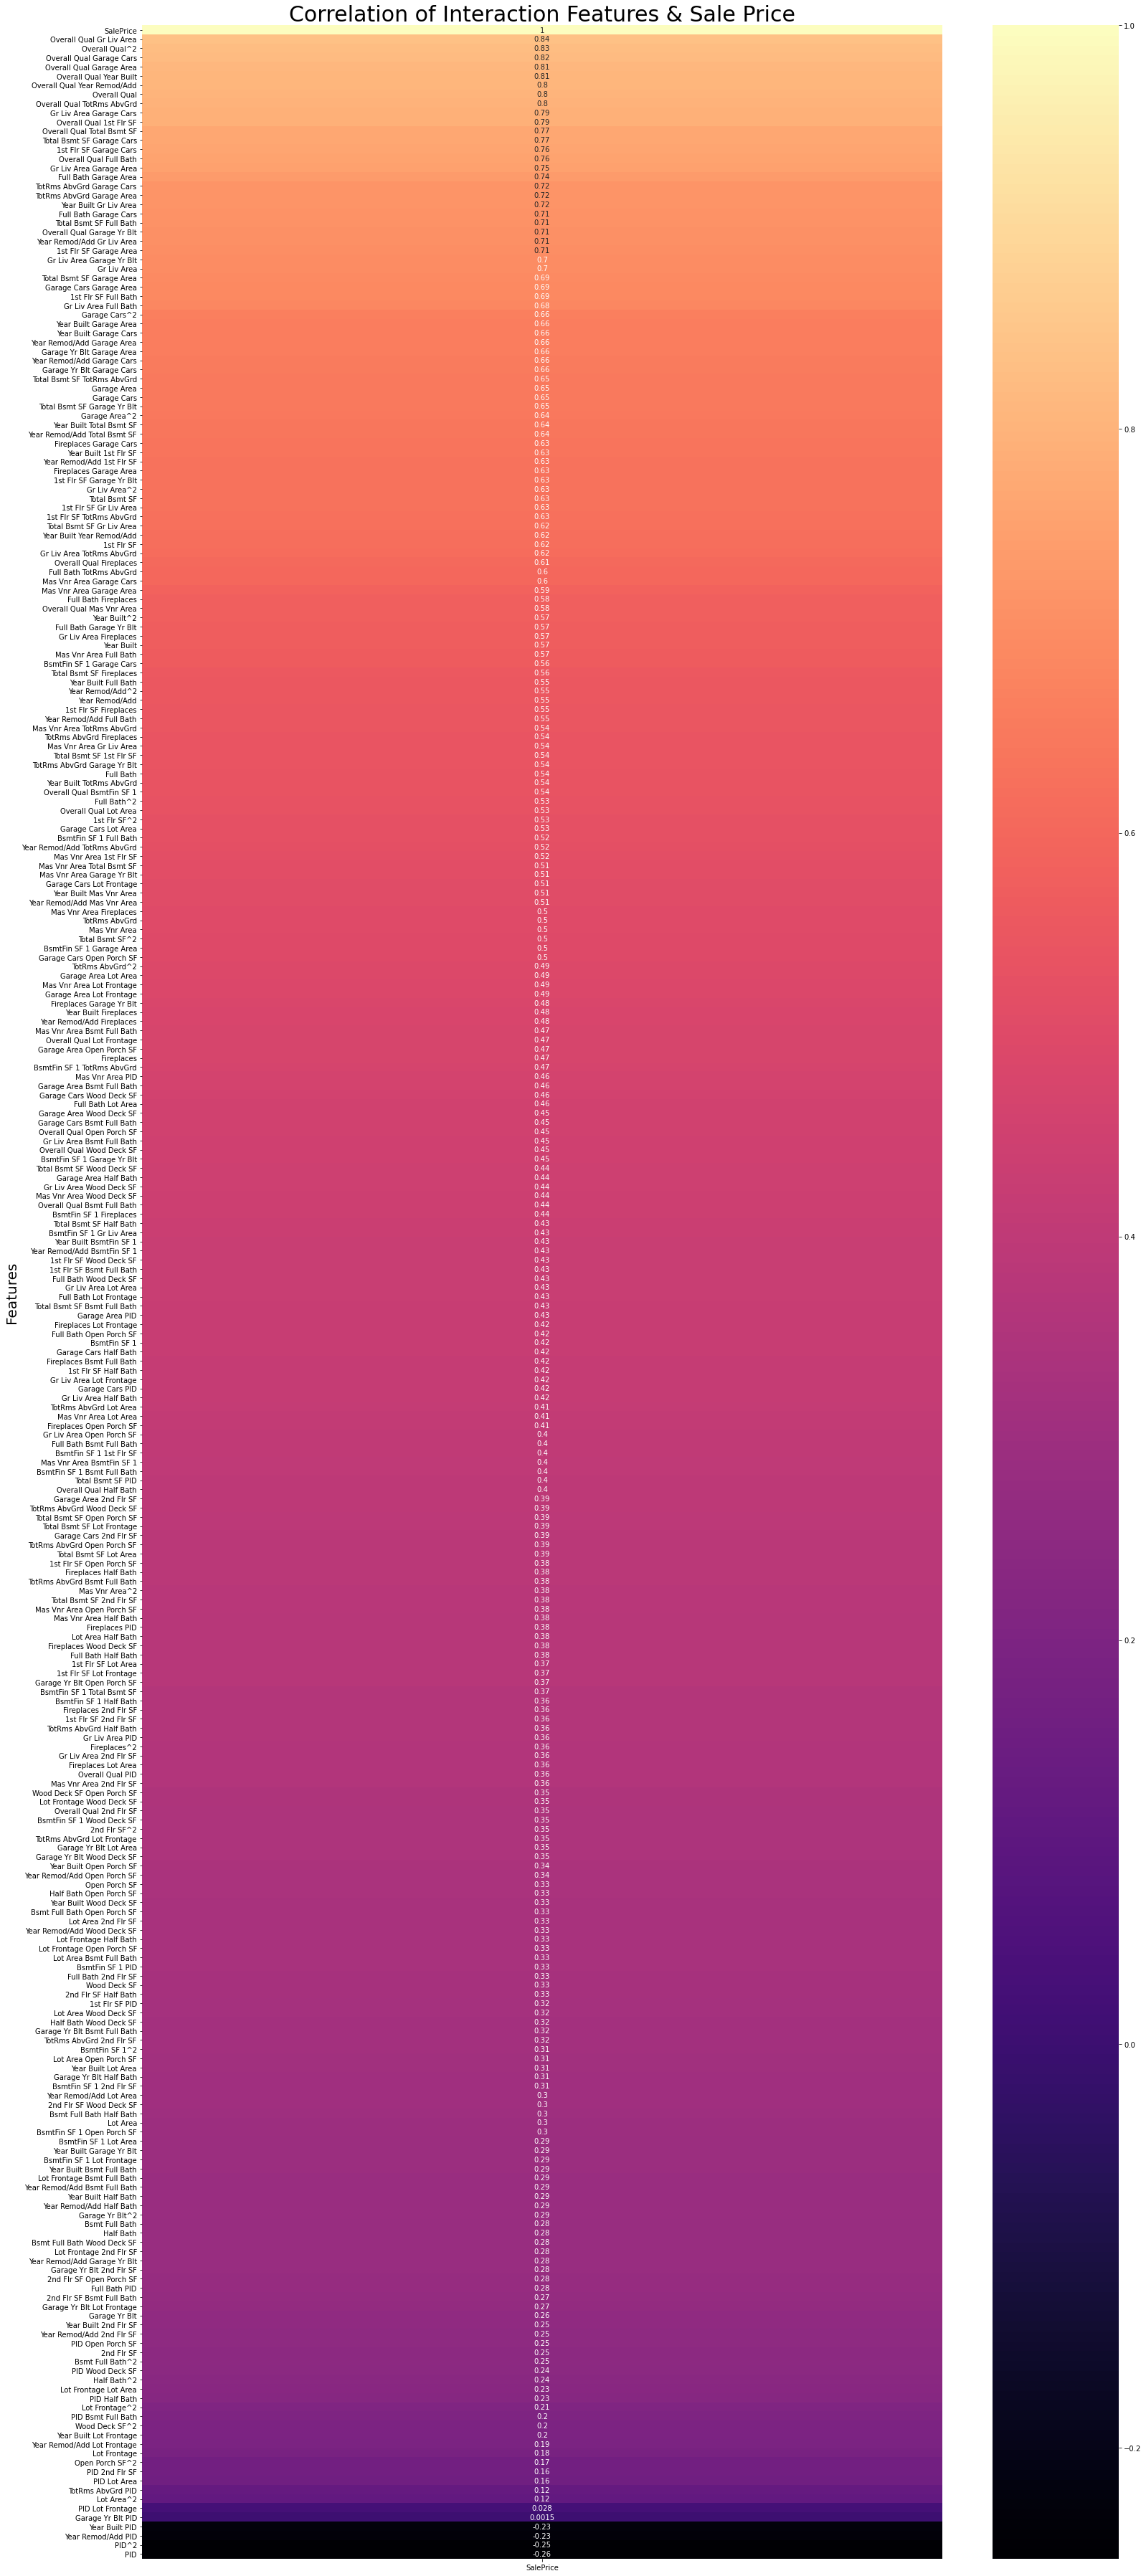

In [61]:
# Heatmap showing interaction correlations
plt.figure(figsize=(25,65))
intcr = sns.heatmap(interaction_df.corr()[['SalePrice']].sort_values('SalePrice', ascending = False), annot = True, cmap = 'magma')
intcr.set_title('Correlation of Interaction Features & Sale Price', fontsize = 30)
intcr.set_ylabel('Features', fontsize = 20.0)
intcr.tick_params(axis="x", labelsize=10);

**Fifth Model**

In [62]:
# Setting up train test split with polynomial features
X_train, X_test, y_train, y_test = train_test_split(interaction_df.drop('SalePrice', axis = 1), cdata['SalePrice'])

# scale it
ss = StandardScaler()
Z_train = ss.fit_transform(X_train)
Z_test = ss.transform(X_test)

# setting up first ridge model
r_1 = RidgeCV(alphas = np.logspace(0, 3, 200), cv = 5, scoring = 'r2')
r_1.fit(Z_train, y_train)

# Print scores
print(f'Train Score: {r_1.score(Z_train, y_train)}')
print(f'Test Score: {r_1.score(Z_test, y_test)}')
print(f'Train RMSE: {mean_squared_error(y_train, r_1.predict(Z_train), squared= False)}')
print(f'Test RMSE: {mean_squared_error(y_test, r_1.predict(Z_test), squared=False)}')

Train Score: 0.8829629897933133
Test Score: 0.8426701362069058
Train RMSE: 26231.894368595
Test RMSE: 34296.26020548763


In [63]:
# Filtering all the polynomial features to only have correlation higher than .3
cnames = interaction_df.columns
inthcorr = []

for k in cnames:
     if np.absolute(corrmap(k, interaction_df).head(1).values) >=  .3:
             inthcorr.append(k)

interaction_df = interaction_df[inthcorr]

**Sixth Model**

In [64]:
X_train, X_test, y_train, y_test = train_test_split(interaction_df.drop('SalePrice', axis = 1), cdata['SalePrice'])
# scale it
ss = StandardScaler()
Z_train = ss.fit_transform(X_train)
Z_test = ss.transform(X_test)


r_2 = RidgeCV(alphas = np.logspace(0,3, 200), cv = 4, scoring = 'r2')
r_2.fit(Z_train, y_train)

print(f'Train Score: {r_2.score(Z_train, y_train)}')
print(f'Test Score: {r_2.score(Z_test, y_test)}')

print(f'\n Train RMSE: {mean_squared_error(y_train, r_2.predict(Z_train), squared= False)}')
print(f'Test RMSE: {mean_squared_error(y_test, r_2.predict(Z_test), squared=False)}')
print(interaction_df.shape)

Train Score: 0.9306450199697327
Test Score: 0.805214040311704

 Train RMSE: 21116.967621352298
Test RMSE: 33634.89858584023
(2051, 227)


In [65]:
# Calculates the intersection between the polynomial interactions and our previous data with categorical features
intersect = [value for value in interaction_df.columns if value in strong3]

# creates new data frame that is the combination between the two
intnstr = interaction_df.join(cweak[strong3].drop(intersect, axis = 1))

In [66]:
# clean up interaction_df to only have high correlation 
cnames = intnstr.columns
fincol = []

for k in cnames:
     if np.absolute(corrmap(k, intnstr).head(1).values) >= .2:
             fincol.append(k)

len(fincol)

finaldf = intnstr[fincol]
finaldf.shape

(2051, 273)

**Seventh Model**

In [67]:
# Creating the test train split
X_train, X_test, y_train, y_test = train_test_split(finaldf.drop('SalePrice', axis = 1), cdata['SalePrice'])

# scale it
ss = StandardScaler()

# transformers, scalars in disguise
Z_train = ss.fit_transform(X_train)
Z_test = ss.transform(X_test)

# ridge model and fit
r_3 = RidgeCV(alphas = np.logspace(0,3, 200), cv = 5, scoring = 'r2')
r_3.fit(Z_train, y_train)

print(f'Train Score: {r_3.score(Z_train, y_train)}')
print(f'Test Score: {r_3.score(Z_test, y_test)}')
print(f'Train RMSE: {mean_squared_error(y_train, r_3.predict(Z_train), squared= False)}')
print(f'Test RMSE: {mean_squared_error(y_test, r_3.predict(Z_test), squared=False)}')

Train Score: 0.9353597216837345
Test Score: 0.9089059397113372
Train RMSE: 20065.370868124563
Test RMSE: 24199.286495528653


Text(0, 0.5, 'Residual')

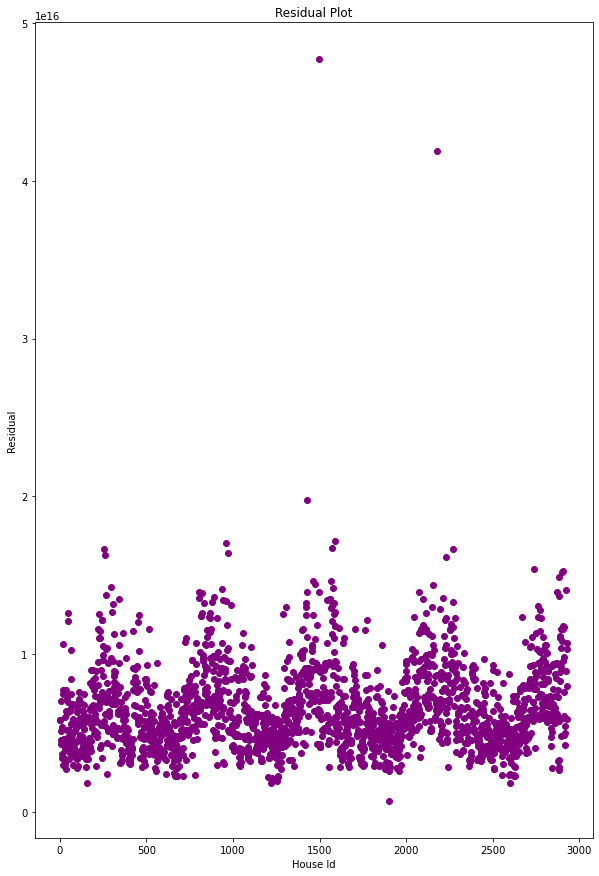

In [68]:
#Plotting residuals for the seventh model, it seems decently distributed however there are some outliers (less outliers than the fourth model and less severe outliers)
plt.figure(figsize = (10, 15))
residuals = finaldf['SalePrice'] - r_3.predict(finaldf.drop('SalePrice', axis = 1))
plt.plot(residuals, 'o', color='purple')
plt.title("Residual Plot")
plt.xlabel("House Id")
plt.ylabel("Residual")

# Small lasso model using the finaldf <a class="anchor" id="SLM"></a>

In [69]:
# Picking best alpha for lasso
l_alpha = np.logspace(1,1.5,100)
lasso = LassoCV(alphas = l_alpha, cv = 10)
lasso.fit(Z_train, y_train)

# it seems to do about as well as the ridge model, future exploration on this model would be good
print(f'Lasso Score (Train) is {lasso.score(Z_train, y_train)}')
print(f'Lasso Score (Test) is {lasso.score(Z_test, y_test)}')

Lasso Score (Train) is 0.9403004949534333
Lasso Score (Test) is 0.9062699631257899


Text(0, 0.5, 'Residual')

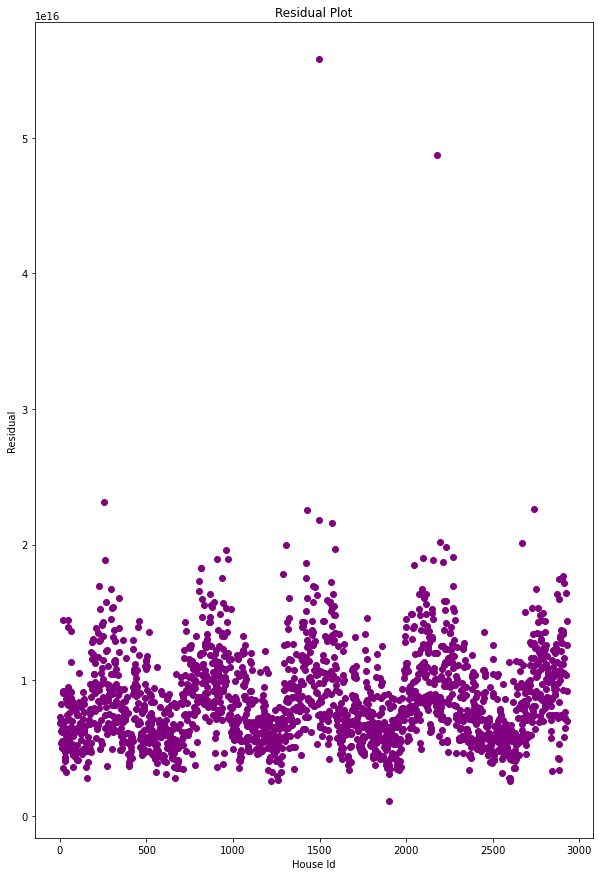

In [70]:
#Plotting residuals for the lasso model, it seems to be very similar to the ridge residuals (two big outliers)
plt.figure(figsize = (10, 15))
residuals = finaldf['SalePrice'] - lasso.predict(finaldf.drop('SalePrice', axis = 1))
plt.plot(residuals, 'o', color='purple')
plt.title("Residual Plot")
plt.xlabel("House Id")
plt.ylabel("Residual")

# Plotting final model performance <a class="anchor" id="PFM"></a>

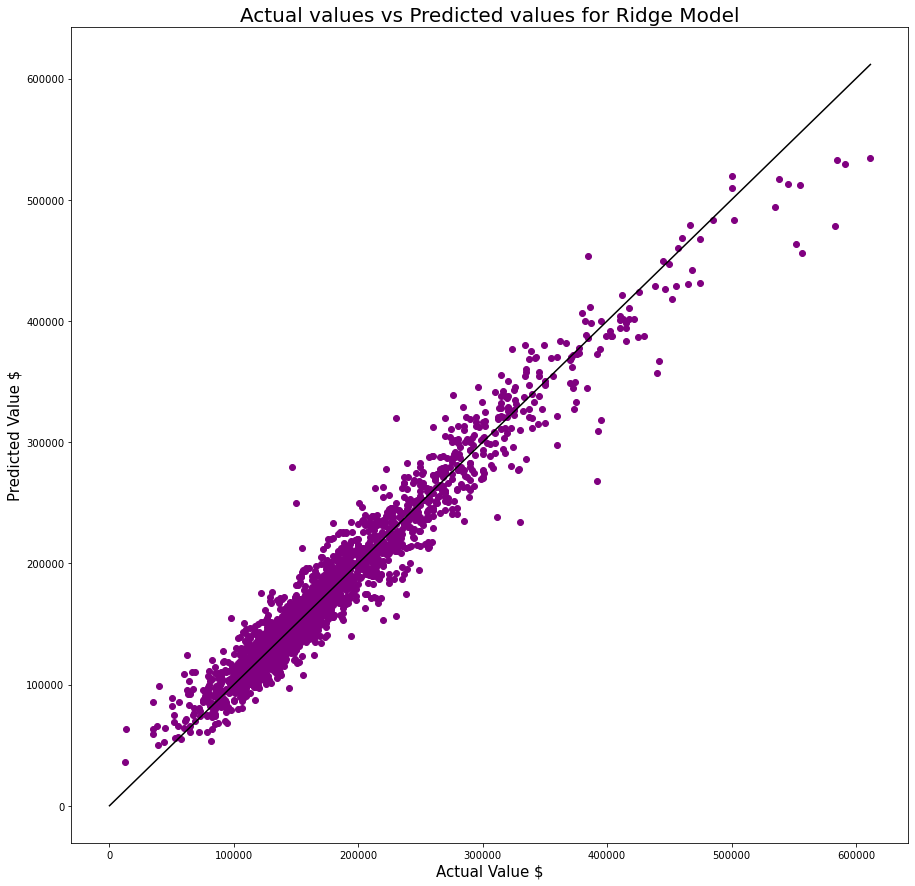

In [93]:
# plotting actual price vs predicted price with the final model I used (Ridge)
plt.figure(figsize = (15, 15))
preds = r_3.predict(finaldf.drop('SalePrice', axis = 1))
actual = finaldf['SalePrice']
plt.scatter(actual, preds, c = 'purple')

#labeling the axes
plt.xlabel('Actual Value $', fontsize = 15)
plt.ylabel('Predicted Value $', fontsize = 15)
plt.title('Actual values vs Predicted values for Ridge Model', fontsize = 20)

#creating a line of best fit
plt.plot([0, np.max(actual)], [0, np.max(actual)], color = 'black');

# Creating Final Test DF to put into the best model (Ridge) <a class="anchor" id="FTD"></a>

In [71]:
# Instantiating poly for test
testpoly = PolynomialFeatures(degree=2, include_bias=False)

# remove 'SalePrice' from strong as we do not want it in our test data
strong.remove('SalePrice')

# Getting numerical interactions for test
Testinteractions = test[strong + weak].select_dtypes(include = np.number)

In [72]:
#fitting to testinteractions
TestX_interactions = poly.fit_transform(Testinteractions)


# Making new dataframe with test interactions
Testinteraction_df = pd.DataFrame(TestX_interactions, index = test.index, columns = poly.get_feature_names(Testinteractions.columns))
inthcorr.remove('SalePrice')

# Making the trimmed testinteraction df with only the highly correlated interactions
Testinteraction_df = Testinteraction_df[inthcorr]

In [73]:
# Joining the interactions and categorical columns
Testintnstr = Testinteraction_df.join(testctest[strong3].drop(intersect, axis = 1))
Testintnstr.shape

(878, 324)

In [74]:
# Parsing the final test data down to the filtered correlated columns
fincol.remove('SalePrice')
Testfinaldf = Testintnstr[fincol]
Testfinaldf.shape

(878, 272)

In [75]:
# scale it
ss = StandardScaler()
Z_train = ss.fit_transform(finaldf)

r_3 = RidgeCV(alphas = np.logspace(0,3, 100), cv = 10, scoring = 'r2')
r_3.fit(finaldf.drop('SalePrice', axis = 1), finaldf['SalePrice']);

In [76]:
preds = r_3.predict(Testfinaldf)
testctest['SalePrice'] = preds
output = testctest[['SalePrice']]
output.to_csv('./datasets/1stsub.csv')